In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 1000
n_task = 2
gaus = torch.randn(dim, dim)
u, s, v = torch.svd(gaus)

prob1 = 0.95
prob = [prob1,1-prob1]

task_vectors = u[:n_task]

batch_size = 128

# initial and target
x = torch.nn.Parameter(torch.zeros(dim,))

optim = 'SignGD' # 'SGD' or 'SignGD'


if optim == 'Adam':
    learning_rate = 3e-4
    optimizer = torch.optim.Adam([x], lr=learning_rate)
    
if optim == 'SGD':
    learning_rate = 3e-2
    optimizer = torch.optim.SGD([x], lr=learning_rate)
    
if optim == 'SignGD':
    learning_rate = 3e-4
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.,0.))

target = torch.sum(task_vectors, dim=0)


n_steps = 3000
log = 500
task_abilities = []
losses = []
losses_skill = []
n_uses = []


for i in range(n_steps):

    optimizer.zero_grad()

    # project and get progress
    task_ability = task_vectors @ x
    
    loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
    task_abilities.append(task_ability.detach().numpy())
    losses.append(loss)
    losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

    # mimic gradient
    id = np.random.choice(n_task, batch_size, p=prob)
    task_vectors_batch = task_vectors[id]
    task_ability_batch = task_ability[id]
    
    #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
    neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

    neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
    
    # update 
    x.grad = - neg_grad
    optimizer.step()
    
    # compute #(used dimension)
    alignment = task_vectors * neg_grad[None, :] > 0
    n_used = torch.sum(alignment, dim=1)
    n_uses.append(n_used.detach().numpy())
    
    if i % log == 0:
        print(i)

task_abilities = np.array(task_abilities)
losses = np.array(losses)
n_uses = np.array(n_uses)
losses_skill = np.array(losses_skill)

results = {}
results['losses'] = losses
results['n_uses'] = n_uses
results['task_abilities'] = task_abilities

np.savez(f"./results/effind_2task_{optim}_{prob1}", **results)

0
500
1000
1500
2000
2500


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 1000
n_task = 2
gaus = torch.randn(dim, dim)
u, s, v = torch.svd(gaus)

task_vectors = u[:n_task]


optims = ['Adam', 'SGD', 'SignGD']
prob1s = [0.5,0.9,0.95]


for prob1 in prob1s:
    for optim in optims:
        print(optim, prob1)
        batch_size = 128

        prob = [prob1, 1-prob1]

        # initial and target
        x = torch.nn.Parameter(torch.zeros(dim,))

        #optim = 'SignGD' # 'SGD' or 'SignGD'


        if optim == 'Adam':
            learning_rate = 3e-4
            optimizer = torch.optim.Adam([x], lr=learning_rate)

        if optim == 'SGD':
            learning_rate = 3e-2
            optimizer = torch.optim.SGD([x], lr=learning_rate)

        if optim == 'SignGD':
            learning_rate = 3e-4
            optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.,0.))

        target = torch.sum(task_vectors, dim=0)


        n_steps = 3000
        log = 500
        task_abilities = []
        losses = []
        losses_skill = []
        n_uses = []


        for i in range(n_steps):

            optimizer.zero_grad()

            # project and get progress
            task_ability = task_vectors @ x

            loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
            task_abilities.append(task_ability.detach().numpy())
            losses.append(loss)
            losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

            # mimic gradient
            id = np.random.choice(n_task, batch_size, p=prob)
            task_vectors_batch = task_vectors[id]
            task_ability_batch = task_ability[id]

            #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
            neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

            neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)

            # update 
            x.grad = - neg_grad
            optimizer.step()

            # compute #(used dimension)
            alignment = task_vectors * neg_grad[None, :] > 0
            n_used = torch.sum(alignment, dim=1)
            n_uses.append(n_used.detach().numpy())

            if i % log == 0:
                print(i)

        task_abilities = np.array(task_abilities)
        losses = np.array(losses)
        n_uses = np.array(n_uses)
        losses_skill = np.array(losses_skill)

        results = {}
        results['losses'] = losses
        results['n_uses'] = n_uses
        results['task_abilities'] = task_abilities

        np.savez(f"./results/effind_2task_{optim}_{prob1}", **results)

Adam 0.5
0
500
1000
1500
2000
2500
SGD 0.5
0
500
1000
1500
2000
2500
SignGD 0.5
0
500
1000
1500
2000
2500
Adam 0.9
0
500
1000
1500
2000
2500
SGD 0.9
0
500
1000
1500
2000
2500
SignGD 0.9
0
500
1000
1500
2000
2500
Adam 0.95
0
500
1000
1500
2000
2500
SGD 0.95
0
500
1000
1500
2000
2500
SignGD 0.95
0
500
1000
1500
2000
2500


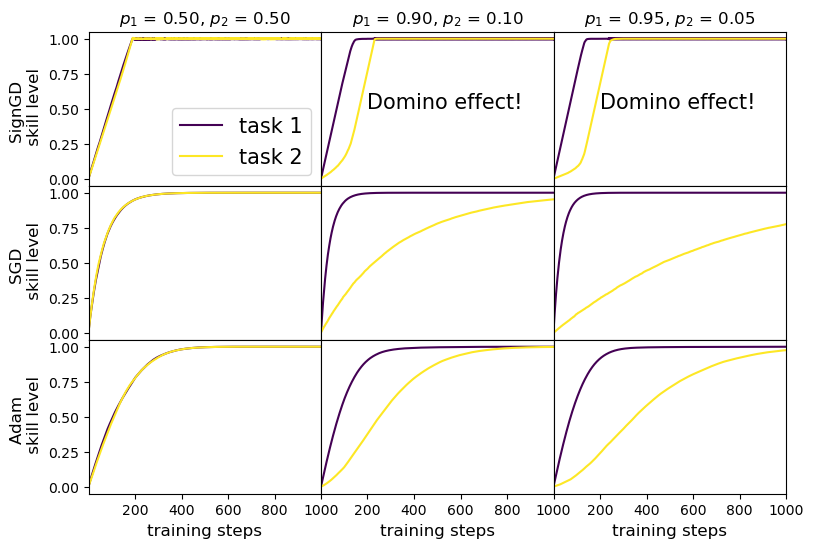

In [6]:
import numpy as np
import matplotlib.pyplot as plt

n_task = 2

optims = ['SignGD', 'SGD', 'Adam']
prob1s = [0.5,0.9,0.95]

optim = 'Adam'
prob1 = 0.95



cmap = plt.get_cmap('viridis') 

plt.figure(figsize=(9,6))

for j in range(3):
    for k in range(3):
        plt.subplot(3,3,3*j+k+1)
        optim = optims[j]
        prob1 = prob1s[k]
        
        loaded_data = np.load(f"./results/effind_2task_{optim}_{prob1}.npz")
        mydict = dict(loaded_data)
        task_abilities = mydict['task_abilities']

        for i in range(n_task):
            plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))

        plt.xlim(1,1000)
        plt.xlabel('training steps', fontsize=12)
        
        if k == 0:
            plt.ylabel('%s \n skill level'%optim, fontsize=12)
        
        if k != 0:
            plt.yticks([])
            
        if j != 2:
            plt.xticks([])
        
        if j == 0:
            plt.title(r'$p_1$ = %.2f, $p_2$ = %.2f'%(prob1, 1-prob1), fontsize=12)
            
        if j == 0 and k == 0:
            plt.legend(['task 1', 'task 2'], loc='lower right', fontsize=15)
            
        plt.ylim(-0.05,1.05)
        
        if j == 0 and (k == 1 or k == 2):
            plt.text(200,0.5,"Domino effect!", fontsize=15)
            
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./plot/2task_trajectory.pdf', bbox_inches='tight')

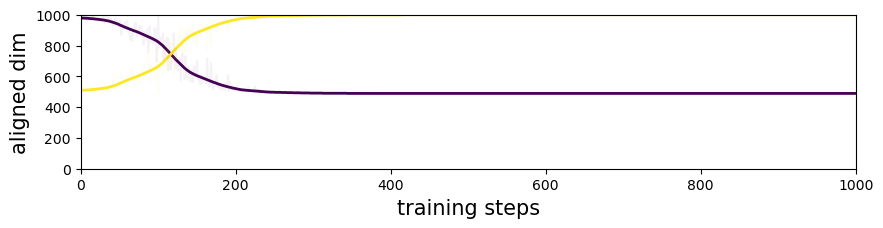

In [148]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))

cmap = plt.get_cmap('viridis') 

for i in range(n_task):
    plt.plot(gaussian_filter1d(n_uses[:,i],sigma=10), color=cmap(i/(n_task-1)), lw=2)
    
#plt.legend(['task 1', 'task 2'], loc='upper right', fontsize=10)

for i in range(n_task):
    plt.plot(np.arange(n_steps), n_uses[:,i], alpha=0.05, color=cmap(i/(n_task-1)))
    
    
'''n_used_sum = 0
for i in range(n_task):
    n_used_sum += gaussian_filter1d(n_uses[:,i],sigma=5) - dim/2
    
plt.plot(n_used_sum+dim/2, color='black')'''
    
plt.xlim(0,1000)
plt.ylim(0,1000)

plt.xlabel('training steps', fontsize=15)
plt.ylabel('aligned dim', fontsize=15)
plt.savefig(f"./plot/2task/grad_align_{prob1:.2f}_sgd.png", bbox_inches='tight')

In [33]:

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

prob1s = np.linspace(0.5,0.99,num=50)

p_ratios = []
t_ratios = []

for prob1 in prob1s:

    print(prob1)
    # get task vectors. all orthogonal
    dim = 1000
    n_task = 2
    gaus = torch.randn(dim, dim)
    u, s, v = torch.svd(gaus)

    #prob1 = 0.5
    prob = [prob1,1-prob1]

    task_vectors = u[:n_task]

    batch_size = 128

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    learning_rate = 3e-4
    #optimizer = torch.optim.SGD([x], lr=learning_rate)
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.,0.))
    target = torch.sum(task_vectors, dim=0)


    n_steps = 500
    log = 500
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []


    for i in range(n_steps):

        optimizer.zero_grad()

        # project and get progress
        task_ability = task_vectors @ x

        loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
        neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

        neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)

        # update 
        x.grad = - neg_grad
        optimizer.step()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    task_abilities = np.array(task_abilities)
    losses = np.array(losses)
    n_uses = np.array(n_uses)
    losses_skill = np.array(losses_skill)

    t1 = np.where(task_abilities[:,0] > 0.9)[0][0]
    t2 = np.where(task_abilities[:,1] > 0.9)[0][0]
    p1_div_p2 = prob[0]/prob[1]
    t2_div_t1 = t2/t1

    p_ratios.append(p1_div_p2)
    t_ratios.append(t2_div_t1)

0.5
0
0.51
0
0.52
0
0.53
0
0.54
0
0.55
0
0.56
0
0.5700000000000001
0
0.58
0
0.59
0
0.6
0
0.61
0
0.62
0
0.63
0
0.64
0
0.65
0
0.66
0
0.67
0
0.6799999999999999
0
0.69
0
0.7
0
0.71
0
0.72
0
0.73
0
0.74
0
0.75
0
0.76
0
0.77
0
0.78
0
0.79
0
0.8
0
0.81
0
0.8200000000000001
0
0.8300000000000001
0
0.8400000000000001
0
0.8500000000000001
0
0.86
0
0.87
0
0.88
0
0.89
0
0.9
0
0.91
0
0.9199999999999999
0
0.9299999999999999
0
0.94
0
0.95
0
0.96
0
0.97
0
0.98
0
0.99
0


In [49]:

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

prob1s = np.linspace(0.5,0.99,num=50)

p_ratios = []
t_ratios3 = []

for prob1 in prob1s:

    print(prob1)
    # get task vectors. all orthogonal
    dim = 1000
    n_task = 2
    gaus = torch.randn(dim, dim)
    u, s, v = torch.svd(gaus)

    #prob1 = 0.5
    prob = [prob1,1-prob1]

    task_vectors = u[:n_task]

    batch_size = 128

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    learning_rate = 3e-4
    #optimizer = torch.optim.SGD([x], lr=learning_rate)
    optimizer = torch.optim.Adam([x], lr=learning_rate)
    target = torch.sum(task_vectors, dim=0)


    n_steps = 3000
    log = 500
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []


    for i in range(n_steps):

        optimizer.zero_grad()

        # project and get progress
        task_ability = task_vectors @ x

        loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
        neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

        neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)

        # update 
        x.grad = - neg_grad
        optimizer.step()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    task_abilities = np.array(task_abilities)
    losses = np.array(losses)
    n_uses = np.array(n_uses)
    losses_skill = np.array(losses_skill)

    t1 = np.where(task_abilities[:,0] > 0.9)[0][0]
    t2 = np.where(task_abilities[:,1] > 0.9)[0][0]
    p1_div_p2 = prob[0]/prob[1]
    t2_div_t1 = t2/t1

    p_ratios.append(p1_div_p2)
    t_ratios3.append(t2_div_t1)

0.5
0
500
1000
1500
2000
2500
0.51
0
500
1000
1500
2000
2500
0.52
0
500
1000
1500
2000
2500
0.53
0
500
1000
1500
2000
2500
0.54
0
500
1000
1500
2000
2500
0.55
0
500
1000
1500
2000
2500
0.56
0
500
1000
1500
2000
2500
0.5700000000000001
0
500
1000
1500
2000
2500
0.58
0
500
1000
1500
2000
2500
0.59
0
500
1000
1500
2000
2500
0.6
0
500
1000
1500
2000
2500
0.61
0
500
1000
1500
2000
2500
0.62
0
500
1000
1500
2000
2500
0.63
0
500
1000
1500
2000
2500
0.64
0
500
1000
1500
2000
2500
0.65
0
500
1000
1500
2000
2500
0.66
0
500
1000
1500
2000
2500
0.67
0
500
1000
1500
2000
2500
0.6799999999999999
0
500
1000
1500
2000
2500
0.69
0
500
1000
1500
2000
2500
0.7
0
500
1000
1500
2000
2500
0.71
0
500
1000
1500
2000
2500
0.72
0
500
1000
1500
2000
2500
0.73
0
500
1000
1500
2000
2500
0.74
0
500
1000
1500
2000
2500
0.75
0
500
1000
1500
2000
2500
0.76
0
500
1000
1500
2000
2500
0.77
0
500
1000
1500
2000
2500
0.78
0
500
1000
1500
2000
2500
0.79
0
500
1000
1500
2000
2500
0.8
0
500
1000
1500
2000
2500
0.81
0
500
1000

In [40]:

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

prob1s = np.linspace(0.5,0.95,num=46)

p_ratios = []
t_ratios2 = []

for prob1 in prob1s:

    print(prob1)
    # get task vectors. all orthogonal
    dim = 1000
    n_task = 2
    gaus = torch.randn(dim, dim)
    u, s, v = torch.svd(gaus)

    #prob1 = 0.5
    prob = [prob1,1-prob1]

    task_vectors = u[:n_task]

    batch_size = 128

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    learning_rate = 3e-2
    optimizer = torch.optim.SGD([x], lr=learning_rate)
    #optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.,0.))
    target = torch.sum(task_vectors, dim=0)


    n_steps = 3000
    log = 500
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []


    for i in range(n_steps):

        optimizer.zero_grad()

        # project and get progress
        task_ability = task_vectors @ x

        loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
        neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

        neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)

        # update 
        x.grad = - neg_grad
        optimizer.step()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    task_abilities = np.array(task_abilities)
    losses = np.array(losses)
    n_uses = np.array(n_uses)
    losses_skill = np.array(losses_skill)

    t1 = np.where(task_abilities[:,0] > 0.9)[0][0]
    t2 = np.where(task_abilities[:,1] > 0.9)[0][0]
    p1_div_p2 = prob[0]/prob[1]
    t2_div_t1 = t2/t1

    p_ratios.append(p1_div_p2)
    t_ratios2.append(t2_div_t1)

0.5
0
500
1000
1500
2000
2500
0.51
0
500
1000
1500
2000
2500
0.52
0
500
1000
1500
2000
2500
0.53
0
500
1000
1500
2000
2500
0.54
0
500
1000
1500
2000
2500
0.55
0
500
1000
1500
2000
2500
0.5599999999999999
0
500
1000
1500
2000
2500
0.57
0
500
1000
1500
2000
2500
0.58
0
500
1000
1500
2000
2500
0.59
0
500
1000
1500
2000
2500
0.6
0
500
1000
1500
2000
2500
0.61
0
500
1000
1500
2000
2500
0.62
0
500
1000
1500
2000
2500
0.63
0
500
1000
1500
2000
2500
0.64
0
500
1000
1500
2000
2500
0.6499999999999999
0
500
1000
1500
2000
2500
0.6599999999999999
0
500
1000
1500
2000
2500
0.6699999999999999
0
500
1000
1500
2000
2500
0.6799999999999999
0
500
1000
1500
2000
2500
0.69
0
500
1000
1500
2000
2500
0.7
0
500
1000
1500
2000
2500
0.71
0
500
1000
1500
2000
2500
0.72
0
500
1000
1500
2000
2500
0.73
0
500
1000
1500
2000
2500
0.74
0
500
1000
1500
2000
2500
0.75
0
500
1000
1500
2000
2500
0.76
0
500
1000
1500
2000
2500
0.77
0
500
1000
1500
2000
2500
0.78
0
500
1000
1500
2000
2500
0.79
0
500
1000
1500
2000
2500
0.7

In [58]:
len(t_ratios2)

46

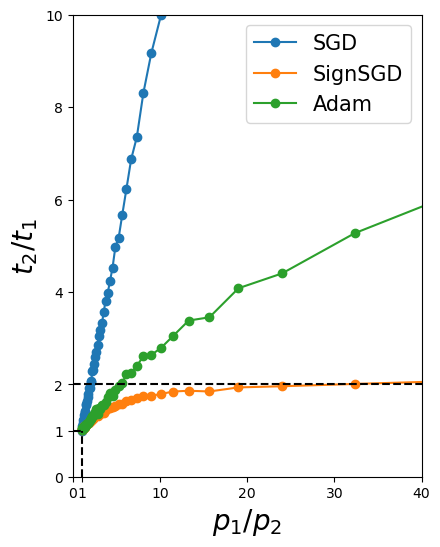

In [61]:


plt.figure(figsize=(4.5,6))

p = np.linspace(0.5,0.95,num=46)
plt.plot(p/(1-p), t_ratios2, marker='o')

p = np.linspace(0.5,0.99,num=50)
plt.plot(p/(1-p), t_ratios, marker='o')

plt.plot(p/(1-p), t_ratios3, marker='o')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$p_1/p_2$', fontsize=20)
plt.ylabel(r'$t_2/t_1$', fontsize=20)
plt.xlim(0,40)
plt.ylim(0,10)
plt.xticks([0,1,10,20,30,40]);
plt.yticks([0,1,2,4,6,8,10])
plt.plot([0,40],[2,2], ls='--', color='black')
plt.plot([0,1],[1,1], color='black', ls='--')
plt.plot([1,1],[0,1], color='black', ls='--')
plt.legend(['SGD', 'SignSGD', 'Adam'], fontsize=15, loc='upper right')
plt.savefig('./plot/2task_t2divt1.pdf', bbox_inches='tight')